# 509 Final Project

* Import Libraries

* Define Functions

* Load MASTER data and/or Business Data

* Pre-Processing

* EDA  

* Linear SVC Train/Test

* SKLEARN Linear SVC Train/Test

* Linear SVC Business Data Results

## Globally import libraries

In [385]:
#! pip install pyLDavis

import pyLDAvis

pyLDAvis.enable_notebook()
from tqdm.auto import tqdm
import spacy
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import numpy as np
import pandas as pd
import pymysql as mysql
import matplotlib.pyplot as plt
import os
import shutil
import re
import logging
import time
import zipfile
import requests
from bs4 import BeautifulSoup
import datetime
import re
import regex as rex
from collections import defaultdict, Counter
import random
import requests
from bs4 import BeautifulSoup
import datetime
import json
from wordcloud import WordCloud 
from tabulate import tabulate
from sklearn.svm import SVC
import textacy.preprocessing as tprep
from textacy.extract import keyword_in_context

import sqlite3
import nltk
from string import punctuation
from nltk.corpus import stopwords
import re
import emoji
from nltk.metrics import ConfusionMatrix
import itertools
import collections
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import LatentDirichletAllocation

#import mysql.connector

# Set pandas global options
pd.options.display.max_rows = 17

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Functions:

### Data pre-processing:

REGEX and NORMALIZE FUNCTIONS

In [211]:
rex_sep = rex.compile(r'&nbsp;')
rex_ucode = rex.compile(r'[\\]u20*')

'''re.sub lambda citation:
https://chat.openai.com/share/402ec66e-2802-4cda-af8c-6f9f5b097d85
'''
sep_lst = []
ucode_lst = []
# Add leading and trailing space to URLs
def rex_replace(text):
    #txt = str(text)
    #print(lambda x: x.replace('&nbsp;', ' '))
    #sep_lst.append(rex_sep.findall(txt))
    #ucode_lst.append(rex_ucode.findall(txt))
    text = text.replace(r'&nbsp;', ' ').replace(r'-', ' ')\
    .replace(r'\n', ' ').replace('\u2063', ' ').replace('\u2066', ' ')\
    .replace('\u2069', ' ').replace('\u200b', ' ').replace('\u200d', ' ')\
    .replace('(click to view)', ' ')\
    .replace('a post shared by', ' ')\
    .replace('app users click here', ' ')\
    .replace('app users: click here', ' ')\
    .replace('app users, click here:', ' ')\
    .replace('click here.', ' ')\
    .replace('click here for more cartoons', ' ')\
    .replace('click here for more', ' ')\
    .replace('click here for more sports coverage on foxnews.com', ' ')\
    .replace('click here for other fox news digital adoptable pets stories', ' ')\
    .replace('click here for the fox news app', ' ')\
    .replace('click here for the latest fox news reporting', ' ')\
    .replace('click here for topline and cross tabs conducted', ' ')\
    .replace('click here to hear more', ' ')\
    .replace('click here to ge the fox news app', ' ')\
    .replace('click here to get the fox news app', ' ')\
    .replace('click here to get the opinion newsletter', ' ')\
    .replace('click here to learn more', ' ')\
    .replace('click here to read more', ' ')\
    .replace('click here to sign up for our health newsletter', ' ')\
    .replace('click here to sign up for our lifestyle newsletter', ' ')\
    .replace('click here to sign up for our opinion newsletter', ' ')\
    .replace('click here to sign up for the entertainment newsletter', ' ')\
    .replace('click here to subscribe and get your first year of fox nation free of charge', ' ')\
    .replace('click here to view', ' ')\
    .replace("click to get kurt's cyberguy newsletter with quick tips, tech reviews, security alerts and easy how to's to make you smarter", ' ')\
    .replace("click to get kurt's cyberguy newsletter with security alerts, quick tips, tech reviews, security and easy how to's to make you smarter", ' ')\
    .replace("click to get kurt's free cyberguy newsletter with quick tips, tech reviews, security alerts and easy how to's to make you smarter", ' ')\
    .replace("click to get kurt's free cyberguy newsletter with security alerts, quick tips, tech reviews, and easy how to's to make you smarter", ' ')\
    .replace('click to get the fox news app', ' ')\
    .replace('fox news digital', ' ')\
    .replace('request for comment', ' ')\
    .replace('the ap ', ' ')\
    .replace('copyright © 2023 breitbart', ' ')\
    .replace('all rights reserved', ' ')\
    .replace('copyright 2023 cyberguy.com', ' ')\
    .replace('copyright 2023 fox news network', ' ')\
    .replace('copyright 2023 viq media transcription', ' ')\
    .replace("please let us know if you're having issues with commenting", ' ')\
    .replace('view this post on instagram', ' ')
    #txt = txt
    #text = text.replace(r'200b', 'd171c')
    #text = rex_ucode.sub('', text)
    return text

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

LEMMATIZATION FUNCTION

In [212]:
nlp_trans = spacy.load('en_core_web_sm')

def lemma(text):
    trans_txt = nlp_trans(text)
    tokens = [t.lemma_ for t in trans_txt]
    return tokens

* CASE LOAD 
* STOPWORD REMOVAL 
* URL REMOVAL 
* EMOJI REMOVAL 
* PUNCTUATION REMOVAL 
* MESSY TEXT REMOVAL
* TOKENIZE

In [217]:
# CASE LOAD, REMOVE STOPWORDS,
# EMOJI and PUNCTUATION REMAL,
# URL REMOVAL
# TOKENIZE
# REMOVE MESSY text

punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

sw = stopwords.words("english")
sw = sw + ['nan']
sw = sw + ['said'] + ['news'] + ['us'] + ['reuters'] + ['ap'] \
    + ['fox'] + ['cnn'] + ['breitbart'] + ['digital'] + ['follow'] \
    + ['associated press'] + ['press contributed'] + ['press'] \
    + ['dont'] + ['2023'] + ['told digital'] + ['associated contributed']\
    + ['contributed report'] + ['associated'] + ['contributed'] +\
    ['report'] + ['continued'] + ['reportedly'] + ['im']

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

def emoji_split(text):
    return("".join([' ' + ch + ' ' if emoji.is_emoji(ch) else ch for ch in text]))

def remove_stop(tokens) :
    # modify this function to remove stopwords

    return[t for t in tokens if t not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])
    
def remove_url(text):
    return(re.sub(r'http\S+', '', text))

def remove_messy(text): # remove words that give away the source
    text1=re.sub(r'cnn', '', text)
    text2=re.sub(r'fox', '', text1)
    text3=re.sub(r' — ', '', text2)
    text4=re.sub(r'breitbart', '', text3)
    return(re.sub(r'\\n', '', text4))

# two pipelines to either tokenize or simply remove punctuation
# and lowercase as we will need to extract feature words:

full_pipeline = [str.lower, remove_url, rex_replace, emoji_split, remove_messy, 
                 remove_punctuation, tokenize, remove_stop]
first_pipeline = [str.lower, remove_url, rex_replace, emoji_split, remove_messy, 
                  remove_punctuation]


def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

### Feature extraction Function:

In [7]:
def conv_features(text,fw) :
     feature_set=dict()
     for word in text.split():
          if word in fw:
               feature_set[word]=True
     return(feature_set)

### EDA functions:

* GET PATTERNS
* WORD COUNTS
* WORDCLOUD
* TOPIC MODELING

In [8]:
def get_patterns(text_analyze, num_words, T):
    if(len(text_analyze)==0):
        raise ValueError("Can't work with empty text object")
    total_tokens = 1
    unique_tokens = 0
    avg_token_len = 0.0
    lexical_diversityP = 0.0
    top_words = []

    # Only applying the token_normal, which takes only alphanumeric values
    # to twitter data:
    if T ==1:
        text_analyze=token_normal(text_analyze)

    total_tokens = len(text_analyze)
    unique_tokens = len(set(text_analyze))
    lexical_diversityP = unique_tokens/total_tokens
    avg_token_len = np.mean([len(ta) for ta in text_analyze])

    top_words_1 = collections.Counter(text_analyze)
    top_words = top_words_1.most_common(num_words)

    results={'tokens': total_tokens,
             'unique_tokens': unique_tokens,
             'avg_token_length': avg_token_len,
             'lexical_diversity': lexical_diversityP,
             'top_words': top_words}
    return(results)

In [9]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
# Here, we only apply splitting to the lyrics data due to the difference
# in dataframe/data ingestion between twitter and lycis data:
    
#def count_words(df, column='tokens', preprocess=None, min_freq=2, split=0):
def count_words(x, preprocess=None, min_freq=2, split=0):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    #counter = collections.Counter()
    #top_words_1 = collections.Counter(text_analyze)
    #top_words = top_words_1.most_common(num_words)
    if split == 0:
        counter = collections.Counter(x)
    else: 
        counter = collections.Counter(x.split())

    #df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [10]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], 
                                    abs(words[largest[i]]*100.0/total)))

### Load Data from CSV's:

**Full Dataset compiled for Training/Test of Classifier**

* From CNN, Breitbart, Fox, and Washington Post:

In [154]:
api_data_complete_df=pd.read_csv('../data/master.csv')


**Client Dataset to collect Classifier Results for Client**

* From The Hill: (already tokenized)

In [13]:
api_data_complete_df_business=pd.read_csv('master_business_TheHill.csv')


#### combining articles into one (no need to run again)

In [ ]:
api_data_complete_df=pd.read_csv('News_API_TheHill_wordcount3.csv')
api_data_complete_df.rename (columns = {'article_parsed':'article_text'}, inplace=True) 


In [364]:
api_data_complete_df_og=pd.read_csv('News_API_TheHill_wordcount.csv')
api_data_complete_df3=pd.read_csv('News_API_TheHill_wordcount3.csv')
Business_frames = [api_data_complete_df_og, api_data_complete_df3]
  
api_data_complete_df = pd.concat(Business_frames)
api_data_complete_df.rename (columns = {'article_parsed':'article_text'}, inplace=True) 


In [366]:
api_data_complete_df.head()

,Unnamed: 0,Source,Author,Title,URL,date,content,article_text,word_count
0,0,The Hill,Zach Schonfeld,Ketanji Brown Jackson issues solo dissent in r...,https://thehill.com/regulation/court-battles/4...,2023-06-01T15:38:33Z,Skip to content\r\nLiberal Justice Ketanji Bro...,\n\nLiberal Justice Ketanji Brown Jackson issu...,510
1,1,The Hill,Brett Samuels,How Biden pulled it off...,https://thehill.com/homenews/administration/40...,2023-06-01T06:31:36Z,"Skip to content\r\nIn late March, the prospect...","\n\nIn late March, the prospects of President ...",1052
2,2,The Hill,the hill,How Christie could be wildcard in 2024 race...,https://thehill.com/homenews/campaign/4029170-...,2023-06-01T12:00:04Z,The Memo: How Chris Christie could be a wildca...,\n\nFormer New Jersey Gov. Chris Christie is v...,883
3,3,The Hill,Alexander Bolton,Schumer announces agreement to pass debt ceili...,https://thehill.com/homenews/senate/4031054-sc...,2023-06-01T23:42:11Z,Senate Majority Leader Chuck Schumer (D-N.Y.) ...,\n\nSenate Majority Leader Chuck Schumer (D-N....,568
4,4,The Hill,Zack Budryk,Kaine introduces amendment to strip Manchin-ba...,https://thehill.com/policy/energy-environment/...,2023-06-01T16:43:29Z,Sen. Tim Kaine (D-Va.) added an amendment to t...,\n\nSen. Tim Kaine (D-Va.) added an amendment ...,456


In [365]:
api_data_complete_df.shape

(181, 9)

## Pre-Process Data: 

(same process done to MASTER and THE_HILL_MASTER):

### CHOOSE 1:

#### Business Data (The Hill)

In [354]:
# If Business data loaded - this data is already
# tokenized, so no need to pre-process: 

#api_data_complete_df=api_data_complete_df_business.copy()

#### Train/Test master Data (CNN, Fox, Breitbart, Washington Post)

In [155]:
# Train/Test data loaded:
api_data_complete_df=api_data_complete_df.copy()

TOKENIZE COLUMN added:

In [218]:
# Tokenize text:

api_data_complete_df['tokens']= api_data_complete_df['article_text'].apply(prepare,
                                                     pipeline=full_pipeline)

In [241]:
api_data_complete_df_business['tokens']= api_data_complete_df_business['article_text'].apply(prepare,
                                                     pipeline=full_pipeline)

CLEAN DATA (without tokenizing) COLUMN added:

In [177]:
# Clean data into lowercase/no punctuation:

api_data_complete_df['cleaner_text']= api_data_complete_df['article_text'].apply(prepare,
                                                     pipeline=first_pipeline)

In [242]:
api_data_complete_df_business['cleaner_text']= api_data_complete_df_business['article_text'].apply(prepare,
                                                     pipeline=first_pipeline)

In [158]:
# These results change depending on the data loaded that is being worked on:

api_data_complete_df.shape

(4509, 9)

### If TRAIN data used: LABEL target variable:

In [159]:
# Add target variable values:

api_data_complete_df['Political_Lean'] = np.where((api_data_complete_df['source_name'] == "CNN") | \
                                                  (api_data_complete_df['source_name'] == \
                                                   "The Washington Post"), 'Left', 'Right')

Saving new MASTER CSV;s (tokenized/labeled/etc) for the Business and training datasets

In [369]:
#api_data_complete_df.to_csv("master_business_TheHill.csv", sep=',')

----------

## EDA


### Add Word Counts Columns:

In [363]:
api_data_complete_df=pd.read_csv('master_tokenized_labeled_af.csv')


In [153]:
api_data_complete_df.head()

,source_name,author,title,url,publish_date,content,article_text,tokens,cleaner_text,Political_Lean,word_count_tokens,word_count_cleaner
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,"[travelers, alabama, driving, interstate, 65, ...",travelers in alabama driving on interstate 65 ...,Left,566,933
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,"[federal, prosecutor, may, nearing, decision, ...",a federal prosecutor may be nearing a decision...,Left,638,1085
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,"[federal, appeals, court, tuesday, cleared, wa...",a federal appeals court tuesday cleared the wa...,Left,510,858
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...","[speaking, orlando, november, 2015, republican...",speaking in orlando in november 2015 republica...,Left,534,960
5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...","[“look, know, country’s, going, wrong, directi...",“look we know our country’s going in the wrong...,Left,390,743


In [178]:
api_data_complete_df['word_count_tokens'] = api_data_complete_df['tokens'].apply(lambda x: \
                                                                                 len(str(x).split(" ")))
#api_data_complete_df['word_count'] = api_data_complete_df['article_text'].apply(lambda x: len(str(x).split(" ")))

In [179]:
api_data_complete_df['word_count_cleaner'] = api_data_complete_df['cleaner_text'].apply(lambda x:\
                                                                                        len(str(x).split(" ")))

In [180]:
api_data_complete_df['word_count_tokens'].mean()

428.96517302573204

In [181]:
api_data_complete_df = api_data_complete_df[api_data_complete_df['word_count_tokens']>1]

### Remove "centered" authors from Training/Test Data:

In [182]:
# Removing Reuters, ms, and Associated Press authors from data:

api_data_complete_df2 = api_data_complete_df[~api_data_complete_df['author'].isin(['msn', 'Associated Press', 'Reuters'])]

display(api_data_complete_df2.head())

display(api_data_complete_df2['Political_Lean'].value_counts())

,source_name,author,title,url,publish_date,content,article_text,tokens,cleaner_text,Political_Lean,word_count_tokens,word_count_cleaner
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,"[travelers, alabama, driving, interstate, 65, ...",travelers in alabama driving on interstate 65 ...,Left,564,933
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,"[federal, prosecutor, may, nearing, decision, ...",a federal prosecutor may be nearing a decision...,Left,637,1085
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,"[federal, appeals, court, tuesday, cleared, wa...",a federal appeals court tuesday cleared the wa...,Left,510,858
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...","[speaking, orlando, november, 2015, republican...",speaking in orlando in november 2015 republica...,Left,534,960
5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...","[“look, know, country’s, going, wrong, directi...",“look we know our country’s going in the wrong...,Left,390,743


Political_Lean
Right    2758
Left     1268
Name: count, dtype: int64

In [183]:
api_data_complete_df2.to_csv("master_tokenized_labeled_af.csv", sep=',')

### Word Clouds

In [366]:
# Separate Left and Right Lean articles to analyze as groups:

Left_lean_articles_df=api_data_complete_df2[api_data_complete_df2['Political_Lean']=="Left"]
Right_lean_articles_df=api_data_complete_df2[api_data_complete_df2['Political_Lean']=="Right"]



In [367]:
# Generate list from Left an Right dataframes:

Left_text=[token for sublist in
           Left_lean_articles_df['tokens'] 
           for token in sublist]
Right_text=[token for sublist in 
            Right_lean_articles_df['tokens']
            for token in sublist]


In [195]:
#Left_text

In [15]:
# Left lean vs Right lean word clouds:

Left_Lean_counts = collections.Counter(Left_text)


Right_Lean_counts = collections.Counter(Right_text)



print("\nLeft Leaning Article's top 5 words:\n")
for HT, count in Left_Lean_counts.most_common(5):
    print(f"{HT}: {count}")

print("\nRight Leaning Article's top 5 words:\n")
for HT, count in Right_Lean_counts.most_common(5):
    print(f"{HT}: {count}")


Left Leaning Article's top 5 words:

would: 3591
trump: 3442
also: 2774
house: 2566
people: 2507

Right Leaning Article's top 5 words:

biden: 4453
president: 3767
also: 3621
would: 3512
people: 3375


In [18]:
Left_Lean_counts = count_words(Left_text, split=0)
Right_Lean_counts = count_words(Right_text, split=0)
display(Left_Lean_counts)

,freq
token,
would,3591
trump,3442
also,2774
house,2566
people,2507
...,...
paints,2
houghton,2
912,2


In [ ]:
#her_df=lyrics_data_df.loc[0,:]
#robyn_df=lyrics_data_df.loc[1,:]

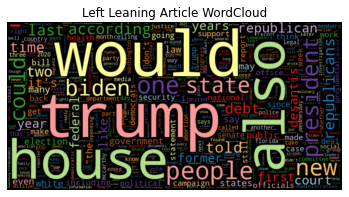

In [19]:
wordcloud(Left_Lean_counts['freq'], title="Left Leaning Article WordCloud", max_words=500)

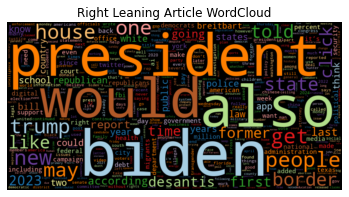

In [20]:
wordcloud(Right_Lean_counts['freq'], title="Right Leaning Article WordCloud", max_words=500)

*Word Clouds reveal that both Left and Right leaning articles tend to have a high word count for their opposition; Left focusing on Trump while the Right focuses on the current president Biden.*

### Topic Modeling NMF:

In [39]:
Left_tfidf_topic = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7, ngram_range=(1,2))
Left_topic_modeling_input = Left_tfidf_topic.fit_transform(Left_lean_articles_df['cleaner_text'])

In [40]:
Right_tfidf_topic = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7, ngram_range=(1,2))
Right_topic_modeling_input = Right_tfidf_topic.fit_transform(Right_lean_articles_df['cleaner_text'])

In [49]:
nmf_text_model_newsL = NMF(n_components=3, random_state=314)
Left_text_matrix = nmf_text_model_newsL.fit_transform(Left_topic_modeling_input)
HLeft_text_matrix = nmf_text_model_newsL.components_

In [50]:
nmf_text_model_newsR = NMF(n_components=3, random_state=314)
Right_text_matrix = nmf_text_model_newsR.fit_transform(Right_topic_modeling_input)
HRight_text_matrix = nmf_text_model_newsR.components_

Display Topics for Left vs Right:

In [51]:
display_topics(nmf_text_model_newsL, Left_tfidf_topic.get_feature_names_out())


Topic 00
  trump (1.75)
  desantis (1.14)
  president (0.32)
  campaign (0.32)
  former (0.31)

Topic 01
  debt (0.97)
  house (0.63)
  mccarthy (0.61)
  biden (0.60)
  debt ceiling (0.57)

Topic 02
  court (0.21)
  state (0.21)
  police (0.15)
  people (0.15)
  abortion (0.14)


In [52]:
display_topics(nmf_text_model_newsR, Right_tfidf_topic.get_feature_names_out())


Topic 00
  biden (0.22)
  debt (0.17)
  house (0.16)
  ai (0.14)
  bill (0.13)

Topic 01
  border (1.72)
  migrants (1.12)
  title (0.71)
  title 42 (0.65)
  42 (0.64)

Topic 02
  desantis (1.29)
  trump (1.24)
  percent (0.59)
  president (0.41)
  florida (0.39)


---

*Topic Modeling using NMF reveals that the top three topics depending on political lean are:*


**Left:**
* Trump/Desantis relationship
* US debt ceiling
* Abortion Laws

**Right:**
* Bills to change Bill of Rights and regulate AI
* Title 42/Migrants
* Relationship DeSantis and Trump

---

### LDA topic modeling for visualization:

In [368]:
Lcount_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=5, max_df=0.7)
Left_count_text_vectors = Lcount_text_vectorizer.fit_transform(Left_lean_articles_df['cleaner_text'])
Left_count_text_vectors.shape

Rcount_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=5, max_df=0.7)
Right_count_text_vectors = Rcount_text_vectorizer.fit_transform(Right_lean_articles_df['cleaner_text'])
Right_count_text_vectors.shape

(2758, 13356)

In [376]:


Left_lda_para_model = LatentDirichletAllocation(n_components = 3, random_state=42)
W_lda_para_matrix_Left = Left_lda_para_model.fit_transform(Left_count_text_vectors)
H_lda_para_matrix_Left = Left_lda_para_model.components_

In [377]:
Right_lda_para_model = LatentDirichletAllocation(n_components = 3, random_state=42)
W_lda_para_matrix_Right = Right_lda_para_model.fit_transform(Right_count_text_vectors)
H_lda_para_matrix_Right = Right_lda_para_model.components_

In [378]:
display_topics(Left_lda_para_model, Lcount_text_vectorizer.get_feature_names_out())



Topic 00
  trump (1.59)
  people (0.49)
  election (0.45)
  president (0.44)
  former (0.38)

Topic 01
  state (0.69)
  people (0.57)
  health (0.44)
  new (0.42)
  abortion (0.39)

Topic 02
  biden (1.01)
  house (0.98)
  republicans (0.67)
  debt (0.67)
  president (0.55)


In [379]:
display_topics(Right_lda_para_model, Rcount_text_vectorizer.get_feature_names_out())



Topic 00
  police (0.46)
  people (0.39)
  also (0.38)
  ai (0.36)
  one (0.35)

Topic 01
  trump (1.05)
  desantis (0.65)
  president (0.50)
  former (0.50)
  also (0.41)

Topic 02
  biden (1.78)
  border (0.94)
  house (0.88)
  president (0.80)
  would (0.53)


In [380]:
lda_display_left = pyLDAvis.lda_model.prepare(Left_lda_para_model, Left_count_text_vectors, 
                                              Lcount_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display_left)

In [381]:
pyLDAvis.save_html(lda_display_left, 'lda_left.html')

In [382]:
lda_display_right = pyLDAvis.lda_model.prepare(Right_lda_para_model, Right_count_text_vectors, 
                                               Rcount_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display_right)

In [383]:
pyLDAvis.save_html(lda_display_right, 'lda_right.html')

---

*Topic Modeling using LDA reveals that the top three topics depending on political lean are:*


**Left:**
* Healthcare
* McCarthy/Biden Debt Ceiling
* Trump/DeSantis relationship
* Justice system, police

**Right:**
* Unclear/school-related (the visualization shows this topic overlaps with the following one a bit)
* President, Biden, Trump, politics
* Justice system, fbi
* Immigration 

----

### Missing Values:

Only one missing value for training data:

In [223]:
#api_data_complete_df2.isna().sum()

----------------


## Modeling:

In [57]:
# Obtain total counts of words in the entire corpus:

word_dist=Counter([item for sublist in api_data_complete_df['tokens'] 
                   for item in sublist])

### Prepare data for modeling (Target defined, clean text as X)

In [46]:
# generate the dict data to then be filtered through
# the filtered_words list:

news_data=dict()

    
news_data=[(api_data_complete_df2.at[index,'cleaner_text'],
            api_data_complete_df2.at[index,'Political_Lean']) \
           for (index,row) in api_data_complete_df2.iterrows()]

### Feature Words filtering:

In [47]:
word_cutoff=5
feature_words2=[]
for word, count in word_dist.items() :
    #for convention_data_df['word_dist']
    if count > word_cutoff :
        feature_words2.append(word)
            
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words2)} as features in the model.")

With a word cutoff of 5, we have 22181 as features in the model.


In [48]:
# Filter the data through the feature words set
# determined above:

featuresets=dict()
featuresets = [(conv_features(text,feature_words2), 
                lean) for (text, lean) in news_data]

### Rough Naive-Bayes Classifier setup and run-through:

In [49]:
random.seed(42)
random.shuffle(featuresets)
test_size = 20


In [50]:
test_set=dict()
train_set=dict()
test_set, train_set = featuresets[:test_size], featuresets[test_size:]

In [51]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.2


In [52]:
# Confusion Matrix:

predicted_labels = [classifier.classify(features) for features, 
                    label in test_set]
gold_labels = [label for features, label in test_set]

cm = ConfusionMatrix(gold_labels, predicted_labels)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

      |      R        |
      |      i      L |
      |      g      e |
      |      h      f |
      |      t      t |
------+---------------+
Right |     <.> 80.0% |
 Left |      . <20.0%>|
------+---------------+
(row = reference; col = test)



### Linear SVC classifier:

#### Prepare Data for Linear SVC (SVM) implementation:

In [184]:
X_train, X_test, Y_train, Y_test = train_test_split(api_data_complete_df2['cleaner_text'],
                                                    api_data_complete_df2['Political_Lean'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=api_data_complete_df2['Political_Lean'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  3220
Size of Test Data  806


In [185]:
# TF-IDF Vectorization for Training/Test Data:

tfidf = TfidfVectorizer(min_df = 10, max_df=0.7, ngram_range=(1,2), stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

#### Hyperparameter tuning:

In [361]:


parameters = {'C':[0.1, 1, 6, 6.5, 8], 'penalty':['l1', 'l2'], 'tol':[0.0000001, 
                                                                      0.00001, 0.0001, 0.001, 0.01]}
svc_grid = LinearSVC(random_state=0)
clf_grid = GridSearchCV(svc_grid, parameters)
clf_grid.fit(X_train_tf, Y_train)

GridSearchCV(estimator=LinearSVC(random_state=0),
             param_grid={'C': [0.1, 1, 6, 6.5, 8], 'penalty': ['l1', 'l2'],
                         'tol': [1e-07, 1e-05, 0.0001, 0.001, 0.01]})

In [362]:
clf_grid.best_params_

{'C': 6, 'penalty': 'l2', 'tol': 1e-07}

The hyperparameter that gave the best results was tolerance at 1e-07, the others brought accuracy down so eliminated them

#### Train and Test Linear SVC model:

In [359]:
# Train Lineary SVC Model with Training Data:

model1 = LinearSVC(random_state=0, tol=1e-7)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-07)

In [389]:
Y_train_pred = model1.predict(X_train_tf)

print ('Training Accuracy Score - ', accuracy_score(Y_train, Y_train_pred))


Training Accuracy Score -  0.9987577639751553


              precision    recall  f1-score   support

        Left       1.00      1.00      1.00      1014
       Right       1.00      1.00      1.00      2206

    accuracy                           1.00      3220
   macro avg       1.00      1.00      1.00      3220
weighted avg       1.00      1.00      1.00      3220

[[1012    2]
 [   2 2204]]


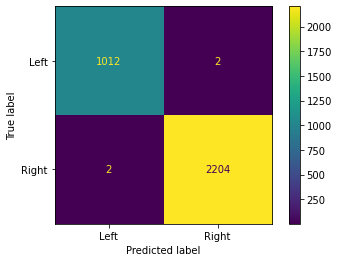

In [436]:
train_svc_pred_cm = confusion_matrix(Y_train, Y_train_pred)

print(classification_report(Y_train, Y_train_pred))
print(train_svc_pred_cm)

train_svc_pred_cm_calc = ConfusionMatrixDisplay(confusion_matrix=train_svc_pred_cm,
                                          display_labels=model1.classes_)
train_svc_pred_cm_calc.plot()
plt.show()

#### Test Results Linear SVC: 

In [360]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
#print ('F1 Score - ', recall_score(Y_test, Y_pred))

Accuracy Score -  0.9069478908188585


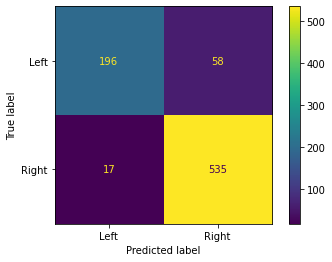

In [188]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

In [189]:
TNmodel1=cm[0][0]
FPmodel1=cm[0][1]
FNmodel1=cm[1][0]
TPmodel1=cm[1][1]

In [190]:
# Results:

TANmodel1=TNmodel1+FPmodel1
TAPmodel1=TPmodel1+FNmodel1
TPPmodel1=FPmodel1+TPmodel1
TPNmodel1=TNmodel1+FNmodel1
GTmodel1=TANmodel1+TAPmodel1
AccuracyM1=(TNmodel1+TPmodel1)/GTmodel1
ErrorRateM1=1-AccuracyM1
SensitivityM1=TPmodel1/(TAPmodel1)
RecallM1=SensitivityM1
SpecificityM1=TNmodel1/TANmodel1
PrecisionM1=TPmodel1/TPPmodel1
F1M1=2*PrecisionM1*RecallM1/(PrecisionM1 + RecallM1)
F2M1=5*(PrecisionM1*RecallM1)/((4*PrecisionM1)+RecallM1)
Fp5M1=(1.25)*(PrecisionM1*RecallM1)/((0.25*PrecisionM1)+RecallM1)

header = ["Accuracy", "Error Rate", "Sensitivity", "Recall", "Specificity",
          "Precision", "F1", "F2", "F0.5"]
data1 = [["Accuracy", AccuracyM1], ["Error Rate", ErrorRateM1],
         ["Sensitivity", SensitivityM1],
         ["Recall", RecallM1], ["Specificity", SpecificityM1],
         ["Precision", PrecisionM1],
         ["F1", F1M1], ["F2", F2M1], ["F0.5", Fp5M1]]

col_names=["Measurement", "Linear SVC Model"]

ModelEvaluationTable = tabulate(data1, headers=col_names,
                                tablefmt="fancy_grid")

print(ModelEvaluationTable)

╒═══════════════╤════════════════════╕
│ Measurement   │   Linear SVC Model │
╞═══════════════╪════════════════════╡
│ Accuracy      │          0.906948  │
├───────────────┼────────────────────┤
│ Error Rate    │          0.0930521 │
├───────────────┼────────────────────┤
│ Sensitivity   │          0.969203  │
├───────────────┼────────────────────┤
│ Recall        │          0.969203  │
├───────────────┼────────────────────┤
│ Specificity   │          0.771654  │
├───────────────┼────────────────────┤
│ Precision     │          0.902192  │
├───────────────┼────────────────────┤
│ F1            │          0.934498  │
├───────────────┼────────────────────┤
│ F2            │          0.955016  │
├───────────────┼────────────────────┤
│ F0.5          │          0.914843  │
╘═══════════════╧════════════════════╛


In [299]:
data1

[['Accuracy', 0.9069478908188585],
 ['Error Rate', 0.09305210918114148],
 ['Sensitivity', 0.9692028985507246],
 ['Recall', 0.9692028985507246],
 ['Specificity', 0.7716535433070866],
 ['Precision', 0.9021922428330523],
 ['F1', 0.9344978165938865],
 ['F2', 0.9550160656908249],
 ['F0.5', 0.91484268125855]]

In [303]:
Data_metric_results_TheHill=pd.DataFrame(data1)
Data_metric_results_TheHill.head()

,0,1
0,Accuracy,0.906948
1,Error Rate,0.093052
2,Sensitivity,0.969203
3,Recall,0.969203
4,Specificity,0.771654


In [304]:

Data_metric_results_TheHill.rename (columns = {0:'Measurement'}, inplace=True) 
Data_metric_results_TheHill.rename (columns = {1:'Result'}, inplace=True) 

(0.0, 1.15)

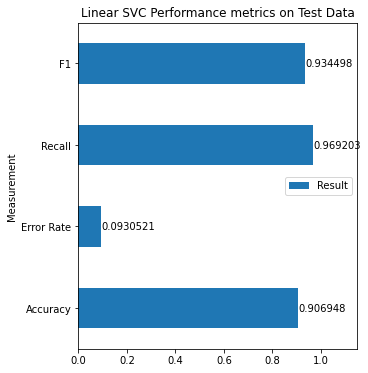

In [319]:
#plt.bar(x=ModelEvaluationTable)


ax=Data_metric_results_TheHill[(Data_metric_results_TheHill['Measurement'] == 'Accuracy') | 
                            (Data_metric_results_TheHill['Measurement'] == 'Recall') |
                            (Data_metric_results_TheHill['Measurement'] == 'F1') |
                            (Data_metric_results_TheHill['Measurement'] == \
                             'Error Rate')].plot(kind="barh", 
                                                 x='Measurement',
                                  figsize=(5,6),
                                  title='Linear SVC Performance metrics on Test Data')
ax.bar_label(ax.containers[0])
ax.set_xlim(right=1.15)

Because the classifier has a harder time classifying the Left class, our Accuracy is lower than Recall for the Right class. But still within acceptable range. F1 score is above .9 which was the goal. This classifier is good to try with the business case data give its speed and simpler design.

#### Save trained SVC model:

In [386]:
# Path to save the pickled model
file_path = "model1_linSVC.pkl"

# Pickle the model
with open(file_path, "wb") as file:
    pickle.dump(model1, file)

print("Model pickled and saved successfully.")

Model pickled and saved successfully.


### SKLEARN SVC Proba Model:

In [363]:
svm = SVC(random_state=0, kernel='linear', probability=True)
svm.fit(X_train_tf, Y_train)

SVC(kernel='linear', probability=True, random_state=0)

In [364]:
Y_pred_sklearn = svm.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_sklearn))

Accuracy Score -  0.8957816377171216


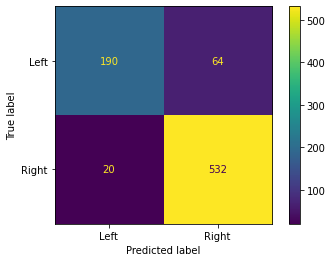

In [203]:
#confusion_matrix(Y_test, Y_pred_sklearn)
cm_sklearn = confusion_matrix(Y_test, Y_pred_sklearn)
disp_sklearn = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn, display_labels = svm.classes_)
disp_sklearn.plot()
plt.show()

In [204]:
SK_TNmodel1=cm_sklearn[0][0]
SK_FPmodel1=cm_sklearn[0][1]
SK_FNmodel1=cm_sklearn[1][0]
SK_TPmodel1=cm_sklearn[1][1]

In [205]:
# Results:

SK_TANmodel1=SK_TNmodel1+SK_FPmodel1
SK_TAPmodel1=SK_TPmodel1+SK_FNmodel1
SK_TPPmodel1=SK_FPmodel1+SK_TPmodel1
SK_TPNmodel1=SK_TNmodel1+SK_FNmodel1
SK_GTmodel1=SK_TANmodel1+SK_TAPmodel1
SK_AccuracyM1=(SK_TNmodel1+SK_TPmodel1)/SK_GTmodel1
SK_ErrorRateM1=1-SK_AccuracyM1
SK_SensitivityM1=SK_TPmodel1/(SK_TAPmodel1)
SK_RecallM1=SK_SensitivityM1
SK_SpecificityM1=SK_TNmodel1/SK_TANmodel1
SK_PrecisionM1=SK_TPmodel1/SK_TPPmodel1
SK_F1M1=2*SK_PrecisionM1*SK_RecallM1/(SK_PrecisionM1 + SK_RecallM1)
SK_F2M1=5*(SK_PrecisionM1*SK_RecallM1)/((4*SK_PrecisionM1)+SK_RecallM1)
SK_Fp5M1=(1.25)*(SK_PrecisionM1*SK_RecallM1)/((0.25*SK_PrecisionM1)+SK_RecallM1)

header = ["Accuracy", "Error Rate", "Sensitivity", "Recall", "Specificity",
          "Precision", "F1", "F2", "F0.5"]
SK_data1 = [["Accuracy", SK_AccuracyM1], ["Error Rate", SK_ErrorRateM1],
         ["Sensitivity", SK_SensitivityM1],
         ["Recall", SK_RecallM1], ["Specificity", SK_SpecificityM1],
         ["Precision", SK_PrecisionM1],
         ["F1", SK_F1M1], ["F2", SK_F2M1], ["F0.5", SK_Fp5M1]]

col_names=["Measurement", "SKLEARN Linear SVC Model"]

SK_ModelEvaluationTable = tabulate(SK_data1, headers=col_names,
                                tablefmt="fancy_grid")

print(SK_ModelEvaluationTable)

╒═══════════════╤════════════════════════════╕
│ Measurement   │   SKLEARN Linear SVC Model │
╞═══════════════╪════════════════════════════╡
│ Accuracy      │                   0.895782 │
├───────────────┼────────────────────────────┤
│ Error Rate    │                   0.104218 │
├───────────────┼────────────────────────────┤
│ Sensitivity   │                   0.963768 │
├───────────────┼────────────────────────────┤
│ Recall        │                   0.963768 │
├───────────────┼────────────────────────────┤
│ Specificity   │                   0.748031 │
├───────────────┼────────────────────────────┤
│ Precision     │                   0.892617 │
├───────────────┼────────────────────────────┤
│ F1            │                   0.926829 │
├───────────────┼────────────────────────────┤
│ F2            │                   0.948645 │
├───────────────┼────────────────────────────┤
│ F0.5          │                   0.905995 │
╘═══════════════╧════════════════════════════╛


### Features of Importance:

In [456]:


# Get the most predictive words

feature_names = tfidf.get_feature_names_out()
#model1.coef_
top_words = sorted(zip(model1.coef_[0], feature_names), reverse=True)[:10]
#svm.coe
#top_words

In [457]:
top_words_df=pd.DataFrame(top_words)

top_words_df.rename (columns = {0:'var_imp'}, inplace=True) 
top_words_df.rename (columns = {1:'feature'}, inplace=True) 

In [458]:
top_words_df.head()

,var_imp,feature
0,1.578366,bidens
1,1.556567,london
2,1.493616,trumps
3,1.359869,amp
4,1.322696,thats


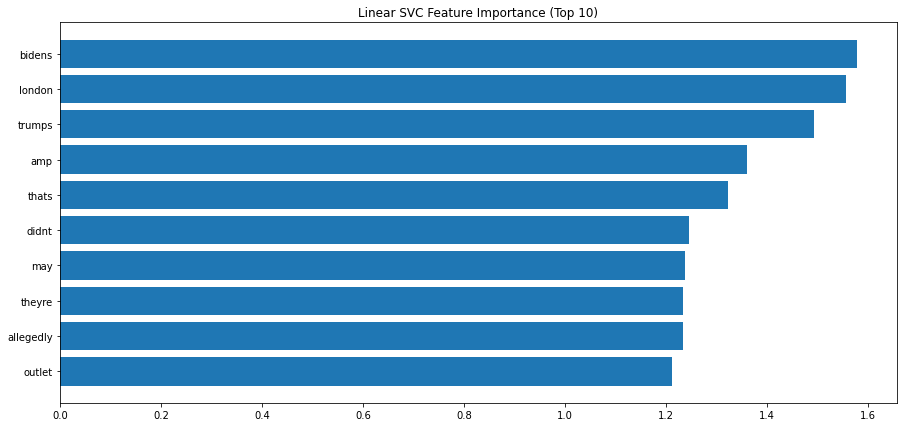

In [460]:
top_words_df.sort_values('var_imp',inplace=True)
plt.figure(figsize=(15,7))
plt.title('Linear SVC Feature Importance (Top 10)')
plt.barh([x for x in range(len(top_words_df['var_imp']))], top_words_df['var_imp'],
         tick_label=top_words_df['feature'])
plt.show()

These words are difficult to analyze without context. However, they help us know if there are any words that are indicative more of the journal/attributes of the news source that might give away the label instead of actual words in the articles that are relevant to political lean. We used this and found that certain phrases were indicating Fox News or other sources which might have helped drive accuracy deceptively high. This output helps us know that it is the text within articles that have helped classify the articles and develop our classifier.

----

## Apply Classifier to Business Client Data:

In [243]:
#Centered data Prep classification:

X_data = api_data_complete_df_business['cleaner_text']

In [244]:
# TF-IDF Vectorization for Business application:

X_Data_Centered = tfidf.transform(X_data)

### Linear SVD:

In [245]:
Data_Classification_Centered = model1.predict(X_Data_Centered)


In [246]:
print(api_data_complete_df_business['Author'])

0        Zach Schonfeld
1         Brett Samuels
2              the hill
3      Alexander Bolton
4           Zack Budryk
             ...       
176        Tobias Burns
177       Julia Mueller
178      Caroline Vakil
179        Tobias Burns
180       Lauren Sforza
Name: Author, Length: 181, dtype: object


In [247]:
Data_Classification_Centered

array(['Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right',
       'Left', 'Left', 'Right', 'Left', 'Left', 'Right', 'Left', 'Left',
       'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Left',
       'Right', 'Left', 'Left', 'Right', 'Left', 'Right', 'Right',
       'Right', 'Left', 'Left', 'Right', 'Left', 'Left', 'Right', 'Left',
       'Left', 'Right', 'Right', 'Left', 'Right', 'Left', 'Left', 'Left',
       'Right', 'Right', 'Right', 'Left', 'Right', 'Left', 'Right',
       'Right', 'Left', 'Left', 'Left', 'Right', 'Right', 'Left', 'Right',
       'Left', 'Right', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left',
       'Left', 'Left', 'Right', 'Right', 'Left', 'Right', 'Left', 'Right',
       'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right',
       'Right', 'Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Left',
       'Right', 'Right', 'Right', 'Right', 'Left', 'Left', 'Left',
       'Right', 'Left', 'Left', 'Right', 'Left', 'Left', 'Left', 'Left',
 

In [248]:
left=0
right=0
for ii in range(0,len(Data_Classification_Centered)):
    if (Data_Classification_Centered[ii] == 'Left'):
        left=left+1
    elif (Data_Classification_Centered[ii] == 'Right'):
        right=right+1

print('Number of Left Articles: ', left, '\nNumber of Right Articles: ',
      right)


Number of Left Articles:  81 
Number of Right Articles:  100


In [249]:
Data_centered_results=pd.DataFrame(Data_Classification_Centered)

In [250]:
Data_centered_results.rename (columns = {0:'Prediction'}, inplace=True) 



In [251]:
Data_centered_results.head()

,Prediction
0,Left
1,Left
2,Right
3,Right
4,Right


<AxesSubplot:title={'center':'Class Predictions The Hill'}, xlabel='Prediction'>

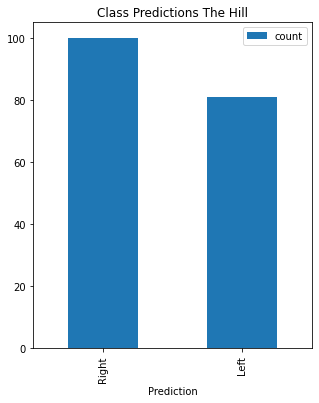

In [252]:
Data_centered_results['Prediction'].value_counts().plot(kind="bar", 
                                  legend=True,
                                  figsize=(5,6),
                                  title='Class Predictions The Hill')

Even with a small dataset of 181 articles, we see almost an even distribution of Right and Left leaning classifications for The Hill. We are interested in seeing the confidence (probability ratings) for these classifications below.

### SKLEARN SVC for probability testing:

In [253]:
AP_predictions_proba = svm.predict_proba(X_Data_Centered)


In [254]:
AP_predictions_proba[0][0]

0.9503953866731141

In [208]:
len(AP_predictions_proba)

181

In [255]:
#from sklearn.svm import SVC
#svm = SVC(kernel='linear', probability=True)
#svm.fit(X_train_tf, Y_train)

#AP_predictions_proba = svm.predict_proba(X_Data_Centered)

for pa in range(0,len(AP_predictions_proba)):
    for pa2 in range(0,1):
        if (AP_predictions_proba[pa][pa2] <= 0.65) & (AP_predictions_proba[pa][pa2] >= 0.5):
            print(pa, ':', AP_predictions_proba[pa][pa2], Data_Classification_Centered[pa])
    

2 : 0.5973377294016616 Right
5 : 0.505540954908968 Right
18 : 0.5137707984203023 Right
27 : 0.5645007945373783 Right
38 : 0.5801257602633187 Right
39 : 0.5756885039402224 Right
46 : 0.5418546159064842 Right
75 : 0.6216635081105005 Right
77 : 0.6216635081105005 Right
84 : 0.6413191667751802 Left
105 : 0.6412982042489684 Left
106 : 0.6412982042489684 Left
115 : 0.5 Right
119 : 0.5 Right
136 : 0.5857159103879271 Right
147 : 0.5893703782219359 Right
150 : 0.5547001230087428 Right
157 : 0.6448261346071565 Left
166 : 0.6448261346071565 Left
168 : 0.6242723322311122 Right
172 : 0.616816668944659 Right
175 : 0.611971953429539 Left
176 : 0.5 Right
179 : 0.5 Right


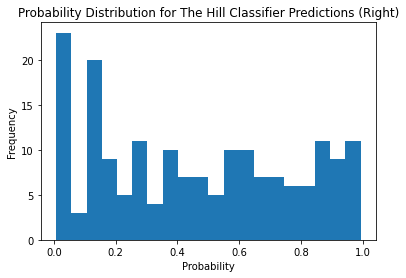

In [296]:
#AP_predictions_proba

plt.hist(AP_predictions_proba[:, 1], bins=20)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution for The Hill Classifier Predictions (Right)')
plt.show()

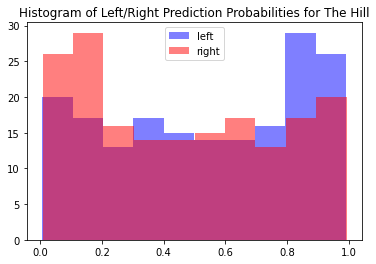

In [481]:
# Plotting histograms
plt.hist(AP_predictions_proba[:, 0], bins=10,
         alpha=0.5, color='blue', label='left')
plt.hist(AP_predictions_proba[:, 1], bins=10,
         alpha=0.5, color='red', label='right')

# Adding legend and title
plt.legend()
plt.title('Histogram of Left/Right Prediction Probabilities for The Hill')

# Displaying the plot
plt.show()

As we had hoped, The Hill appears to be much more balanced in their political lean, as is confirmed by the AllSides data. We did find a slight increase in Right leaning articles, but upon observation of the probability distribution, it is apparant that there are many low probability (low confidence) classifications for the lean. This distribution reveals that even when there is a lean classification, there is not an overwhelming number of confident classifications, which means The Hill is probably still a Centered online publication.

----

## Apply Classifier to AP data:

Collect data saved in CSV and preprocess:

In [261]:
api_data_complete_df_AP=pd.read_csv('News_API_AP_wordcount.csv')


In [262]:
# Tokenize text:

api_data_complete_df_AP['tokens']= api_data_complete_df_AP['article_parsed'].apply(prepare,
                                                     pipeline=full_pipeline)
# Clean data into lowercase/no punctuation:

api_data_complete_df_AP['cleaner_text']= api_data_complete_df_AP['article_parsed'].apply(prepare,
                                                     pipeline=first_pipeline)
api_data_complete_df_AP['word_count_tokens'] = api_data_complete_df_AP['tokens'].apply(lambda x:\
                                                                                       len(str(x).\
                                                                                           split(" ")))

api_data_complete_df_AP = api_data_complete_df_AP[api_data_complete_df_AP['word_count_tokens']>1]

api_data_complete_df_AP.to_csv("master_tokenized_AP.csv", sep=',')


In [269]:
#Centered data Prep classification:

X_data_AP = api_data_complete_df_AP['cleaner_text']

In [270]:
# TF-IDF Vectorization for Business application:

X_Data_Centered_AP = tfidf.transform(X_data_AP)

### Linear SVD:

In [271]:
Data_Classification_Centered_AP = model1.predict(X_Data_Centered_AP)


In [273]:
print(api_data_complete_df_AP['Author'])

0             By ALANNA DURKIN RICHER - Associated Press
1                      By SEUNG MIN KIM Associated Press
2                                         Bernard Condon
3      By KIMBERLEE KRUESI, SARAH RANKIN and DENISE L...
4                                     Brendan Farrington
                             ...                        
183    By LISA MASCARO, KEVIN FREKING and STEPHEN GRO...
184                 By FARNOUSH AMIRI - Associated Press
185              By RADUL RADOVANOVIC - Associated Press
186                 By FARNOUSH AMIRI - Associated Press
187    By LISA MASCARO, KEVIN FREKING and STEPHEN GRO...
Name: Author, Length: 188, dtype: object


In [274]:
Data_Classification_Centered_AP

array(['Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Right',
       'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Right', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Left', 'Right', 'Left', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Left', 'Left', 'Right', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Left', 'Right', 'Left', 'Left', 'Left', 'Right', 'Right',
       'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Left', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right',
       'Left', 'Left', 'Left', 'Right', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Left', 'Left', 'Right', 'Left', 'Left', 'Left', 'Left',
       'Right', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Right', 'Left', 'Right', 'Left', 'Left', 'Left',

In [275]:
left=0
right=0
for ii in range(0,len(Data_Classification_Centered_AP)):
    if (Data_Classification_Centered_AP[ii] == 'Left'):
        left=left+1
    elif (Data_Classification_Centered_AP[ii] == 'Right'):
        right=right+1

print('Number of Left Articles: ', left, '\nNumber of Right Articles: ',
      right)


Number of Left Articles:  164 
Number of Right Articles:  24


In [276]:
Data_centered_results_AP=pd.DataFrame(Data_Classification_Centered_AP)

In [277]:
Data_centered_results_AP.rename (columns = {0:'Prediction'}, inplace=True) 



In [278]:
Data_centered_results_AP.head()

,Prediction
0,Left
1,Left
2,Left
3,Left
4,Left


<AxesSubplot:title={'center':'Class Predictions The Associated Press'}, xlabel='Prediction'>

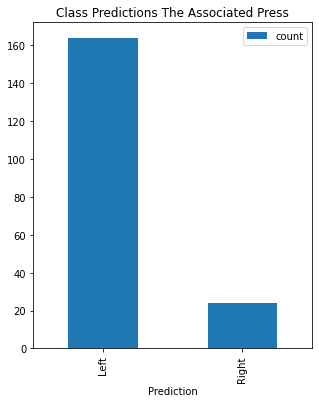

In [279]:
Data_centered_results_AP['Prediction'].value_counts().plot(kind="bar", 
                                  legend=True,
                                  figsize=(5,6),
                                  title='Class Predictions The Associated Press')

An overwhelming majority of Associated press articles were categorized as Left Leaning.

### SKLEARN SVC for probability testing:

In [280]:
AP_predictions_proba_AP = svm.predict_proba(X_Data_Centered_AP)


In [281]:
AP_predictions_proba_AP[0][0]

0.9508323188246903

In [292]:
AP_predictions_proba_AP[1][0]

0.981768860823333

In [294]:
for x in range(0,len(AP_predictions_proba_AP)):
    print(AP_predictions_proba_AP[x][0])
    print(Data_Classification_Centered_AP[x])

0.9508323188246903
Left
0.981768860823333
Left
0.9614810136661492
Left
0.98661746903831
Left
0.891259423999621
Left
0.9906278481561918
Left
0.9427318115573183
Left
0.5336534447481074
Right
0.98661746903831
Left
0.936648044221054
Left
0.981768860823333
Left
0.9630019060086964
Left
0.6940622912199284
Left
0.803178366915479
Left
0.9508323188246903
Left
0.784522092358475
Left
0.9808996379009253
Left
0.26829051965364115
Right
0.9972611023492843
Left
0.9183765606311858
Left
0.9972611023492843
Left
0.9902424311393712
Left
0.9972611023492843
Left
0.9183765606311858
Left
0.8461805772804466
Left
0.9902424311393712
Left
0.08359528360983542
Right
0.9183765606311858
Left
0.7147570033831585
Left
0.7832130005086422
Left
0.7147570033831585
Left
0.9865357100592266
Left
0.7832130005086422
Left
0.7147570033831585
Left
0.9865357100592266
Left
0.278292939996084
Right
0.7096360056069901
Left
0.9611433318272665
Left
0.95338868265243
Left
0.9822489551465043
Left
0.7462156028150145
Left
0.9728761475398888
Left

In [282]:
len(AP_predictions_proba_AP)

188

In [283]:
#from sklearn.svm import SVC
#svm = SVC(kernel='linear', probability=True)
#svm.fit(X_train_tf, Y_train)

#AP_predictions_proba = svm.predict_proba(X_Data_Centered)

for paAP in range(0,len(AP_predictions_proba_AP)):
    for pa2AP in range(0,1):
        if (AP_predictions_proba_AP[paAP][pa2AP] <= 0.65) & \
        (AP_predictions_proba_AP[paAP][pa2AP] >= 0.5):
            print(pa, ':', AP_predictions_proba_AP[paAP][pa2AP], 
                  Data_Classification_Centered_AP[paAP])
    

180 : 0.5336534447481074 Right
180 : 0.6174728227984922 Right
180 : 0.5516811229058828 Left
180 : 0.5888748501334558 Left
180 : 0.5888748501334558 Left
180 : 0.6177850658464895 Left
180 : 0.5747207232364414 Right
180 : 0.5747207232364414 Right
180 : 0.5757840366788696 Left
180 : 0.5757840366788696 Left
180 : 0.5750196473917903 Left
180 : 0.5750196473917903 Left
180 : 0.5750196473917903 Left


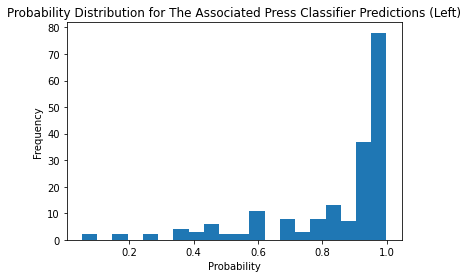

In [286]:
#AP_predictions_proba

plt.hist(AP_predictions_proba_AP[:, 0], bins=20)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution for The Associated Press Classifier Predictions (Left)')
plt.show()

As could be expected from the AllSides experts, the Associated Press online publication is, in fact more confidently left leaning. Since all our left leaning data was first order left lean, this makes sense. The distribution for left leaning data is pretty confident when it is leaning and most articles are categorized as left leaning."

---

### FOX vs MSNBC political audience disparities (presentation data)

In [ ]:
MSNBC_political_demographic = [['MSN',0.95, 0.05],['FOX',0.07, 0.93]]
FOX_political_demographic = []
News_political_demographic=pd.DataFrame(MSNBC_political_demographic)

In [ ]:
News_political_demographic.head()

,0,1,2
0,MSN,0.95,0.05
1,FOX,0.07,0.93


In [ ]:
News_political_demographic.rename (columns = {0:'News_Source'}, inplace=True) 
News_political_demographic.rename (columns = {1:'Left_Leaning'}, inplace=True) 
News_political_demographic.rename (columns = {2:'Right_Leaning'}, inplace=True) 

[Text(0, 0, '0.95'), Text(0, 0, '0.07')]

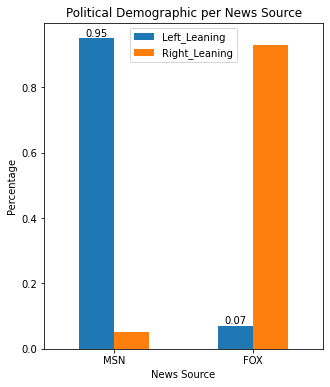

In [474]:
ax2=News_political_demographic.plot(kind="bar", x='News_Source',rot=0,
                                  legend=True,
                                  figsize=(5,6),
                                  xlabel='News Source',
                                  ylabel='Percentage',
                                  title='Political Demographic per News Source')
ax2.bar_label(ax2.containers[0])


### Concentration ratio Charts (presentation data)

In [475]:
Concentration_Ratios=[['Right','nyc',17.49],['Right','reparations',16.89],['Right','aliens',12.7],
                      ['Right','ccp',11.5],['Right','locker',11.07],['Right','comey',9.58],
                      ['Right','lula',9.2],['Right','busch',8.9],['Right','fidelity',8.77],
                      ['Left','anonymity',17.39],['Left','thomnass',16.14],['Left','willis',14.19],
                      ['Left','mehta',13.6],['Left','docket',13.08],['Left','ginni',12.24],
                      ['Left','pork',11.59],
                      ['Left','uncertainty',9.54],['Left','hush',9.74],['Left','gorsuch',9.74]]

Concentration_Ratios_df=pd.DataFrame(Concentration_Ratios)

In [476]:
Concentration_Ratios_df.rename (columns = {0:'Political_Lean'}, inplace=True) 
Concentration_Ratios_df.rename (columns = {1:'Word'}, inplace=True) 
Concentration_Ratios_df.rename (columns = {2:'Factor_of_Concentration'}, inplace=True) 

In [477]:
Concentration_Ratios_df.head()

,Political_Lean,Word,Factor_of_Concentration
0,Right,nyc,17.49
1,Right,reparations,16.89
2,Right,aliens,12.70
3,Right,ccp,11.50
4,Right,locker,11.07


[Text(0, 0, '17.49'),
 Text(0, 0, '16.89'),
 Text(0, 0, '12.7'),
 Text(0, 0, '11.5'),
 Text(0, 0, '11.07'),
 Text(0, 0, '9.58'),
 Text(0, 0, '9.2'),
 Text(0, 0, '8.9'),
 Text(0, 0, '8.77')]

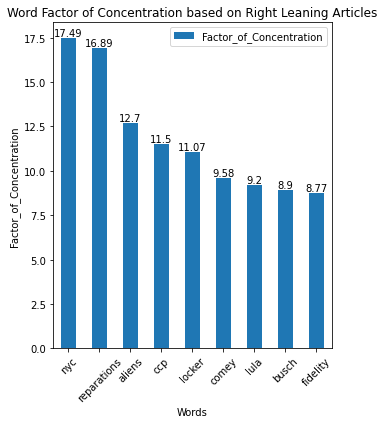

In [478]:
ax3=Concentration_Ratios_df[Concentration_Ratios_df['Political_Lean']=='Right'].plot(kind="bar", 
                                                                                     x='Word',rot=45,
                                  legend=True,
                                  figsize=(5,6),
                                  xlabel='Words',
                                  ylabel='Factor_of_Concentration',
                                  #='Political_Lean',
                                  title='Word Factor of Concentration based on Right Leaning Articles')
ax3.bar_label(ax3.containers[0])

[Text(0, 0, '17.39'),
 Text(0, 0, '16.14'),
 Text(0, 0, '14.19'),
 Text(0, 0, '13.6'),
 Text(0, 0, '13.08'),
 Text(0, 0, '12.24'),
 Text(0, 0, '11.59'),
 Text(0, 0, '9.54'),
 Text(0, 0, '9.74'),
 Text(0, 0, '9.74')]

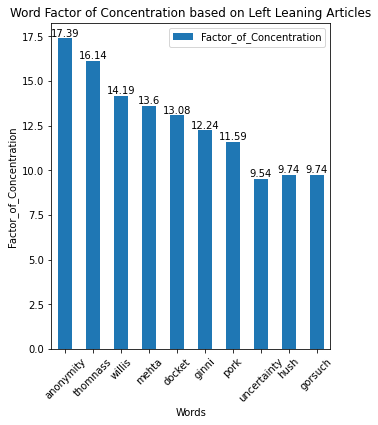

In [479]:
ax3=Concentration_Ratios_df[Concentration_Ratios_df['Political_Lean']=='Left'].plot(kind="bar", 
                                                                                    x='Word',rot=45,
                                  legend=True,
                                  figsize=(5,6),
                                  xlabel='Words',
                                  ylabel='Factor_of_Concentration',
                                  #='Political_Lean',
                                  title='Word Factor of Concentration based on Left Leaning Articles')
ax3.bar_label(ax3.containers[0])